In [1]:
# importing some libraries (not all are currently used)

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image
import imageio
import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar

import random

# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/Fantasy\ Football

Mounted at /content/drive
/content/drive/My Drive/Fantasy Football


In [2]:
df = pd.read_csv('2023_Fantasy_Stats.csv')

In [3]:
df.head()

,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,TD.3,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
0,1.0,Patrick Mahomes*+,KAN,QB,27.0,17.0,17.0,435.0,648.0,5250.0,...,4.0,1.0,2.0,416.0,417.4,435.4,428.9,136.0,1.0,1.0
1,2.0,Josh Jacobs*+,LVR,RB,24.0,17.0,17.0,0.0,0.0,0.0,...,12.0,NaN,NaN,275.0,328.3,335.3,301.8,127.0,1.0,2.0
2,3.0,Christian McCaffrey*,2TM,RB,26.0,17.0,16.0,1.0,1.0,34.0,...,13.0,NaN,NaN,271.0,356.4,362.4,313.9,123.0,2.0,3.0
3,4.0,Derrick Henry*,TEN,RB,28.0,16.0,16.0,2.0,2.0,4.0,...,13.0,NaN,NaN,270.0,302.8,311.8,286.3,122.0,3.0,4.0
4,5.0,Justin Jefferson*+,MIN,WR,23.0,17.0,17.0,2.0,2.0,34.0,...,9.0,1.0,NaN,241.0,368.7,371.7,304.7,119.0,1.0,5.0


<Axes: ylabel='Frequency'>

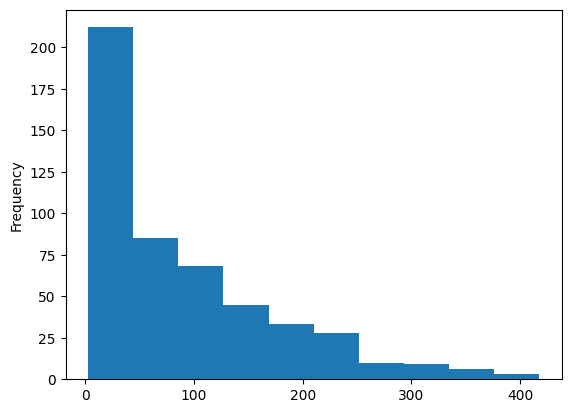

In [4]:
df['PPR'].plot(kind='hist')

In [5]:
# Changing Team Names
team_mapping = {
    'KAN': 1, 'LVR': 2, 'TEN': 3, 'MIN': 4, 'LAC': 5, 'BUF': 6, 'CLE': 7,
    'MIA': 8, 'PHI': 9, 'NYG': 10, 'DAL': 11, 'CIN': 12, 'DET': 13, 'NOR': 14,
    'GNB': 15, 'JAX': 16, 'PIT': 17, 'NWE': 18, 'SEA': 19, 'WAS': 20, 'SFO': 21,
    'TAM': 22, 'BAL': 23, 'ARI': 24, 'CHI': 25, 'DEN': 26, 'CAR': 27, 'NYJ': 28,
    'LAR': 29, 'HOU': 30, 'ATL': 31, '2TM': 32, '3TM': 33
}

def replace_team_names(df, column_name, mapping):
    df[column_name] = df[column_name].map(mapping)
    return df

df = replace_team_names(df, 'Tm', team_mapping)

In [6]:
# Changing positions
position_mapping = {
    'QB': 1, 'RB': 2, 'WR': 3, 'TE': 4, 'K': 5, 'DEF': 6
}
def replace_position_names(df, column_name, mapping):
    # Replace position names with unique numbers using the mapping
    df[column_name] = df[column_name].map(mapping)
    return df


df = replace_team_names(df, 'FantPos', position_mapping)

In [7]:
df = df.drop(index=499)

In [8]:
# Delete rows where 'FantPos' or 'Tm' columns have NaN values
df_cleaned = df.dropna(subset=['FantPos', 'Tm'])

# Reset index after dropping rows (optional)
df = df_cleaned.reset_index(drop=True)

In [9]:
df.tail()

,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,TD.3,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
470,494.0,Tim Jones,16.0,3.0,24.0,17.0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,3.0,6.0,6.0,4.5,NaN,181.0,NaN
471,495.0,Larry Rountree,5.0,2.0,23.0,4.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,3.0,5.3,5.3,4.3,NaN,138.0,NaN
472,496.0,DJ Turner,2.0,3.0,25.0,9.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,3.0,2.6,2.6,2.6,NaN,184.0,NaN
473,497.0,Tylan Wallace,23.0,3.0,23.0,9.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,3.0,7.3,7.3,5.3,NaN,180.0,NaN
474,498.0,Jonathan Ward,32.0,2.0,25.0,8.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,3.0,5.2,5.2,4.2,NaN,139.0,NaN


In [10]:
nan_columns = df.columns[df.isna().any()].tolist()

# Print columns with NaN values
if nan_columns:
    print("Columns with NaN values:")
    for col in nan_columns:
        print(f"- {col}")
else:
    print("No columns contain NaN values.")

Columns with NaN values:
- Y/A
- Y/R
- 2PM
- 2PP
- VBD
- OvRank


In [11]:
columns_to_exclude = ['Rk', 'Player', '2PM', '2PP', 'PPR', 'FantPt', 'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank', 'Y/A', 'Y/R']

# Create DataFrame X excluding specified columns
X = df.drop(columns=columns_to_exclude)
Y = df['PPR']

In [12]:
X.tail()

,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,TD,Int,Att.1,Yds.1,TD.1,Tgt,Rec,Yds.2,TD.2,Fmb,FL,TD.3
470,16.0,3.0,24.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,30.0,0.0,0.0,0.0,0.0
471,5.0,2.0,23.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,19.0,0.0,2.0,2.0,14.0,0.0,0.0,0.0,0.0
472,2.0,3.0,25.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,26.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
473,23.0,3.0,23.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,33.0,0.0,0.0,0.0,0.0
474,32.0,2.0,25.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,25.0,0.0,3.0,2.0,7.0,0.0,0.0,0.0,0.0


In [13]:
Y.tail()

,PPR
470,6.0
471,5.3
472,2.6
473,7.3
474,5.2


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, Y_train)

GradientBoostingRegressor()

In [16]:
# Predict values for the test set
y_pred = model.predict(X_test)

# Print predictions
print(y_pred)

[ 19.42243121  11.46368825 258.17752904 169.64015528  14.28521369
 233.86755817 193.90338927   9.74431397  93.04530766 159.06803562
 163.79214905  38.40054733 153.18289945  61.18426337  34.72691501
  59.3465022    9.54017504 184.42797244  33.82843217  11.46368825
 178.1574232  267.29073214  52.72478687 259.09017475  27.37264616
 261.14960667   9.795167   132.59907654 184.81637522 168.11350544
  14.72395897  10.03124437   9.85447415 177.25248489  99.27403169
 240.03892104  11.69131149  62.54248741  12.12848526 290.24070487
  86.41368896 131.66006632 123.59510815 217.92902183  60.2020685
  12.04438168  23.27007855   9.32183097  30.55734217 236.25689951
 171.11988206   8.84481866   7.9770399    8.35344394 261.03238437
 130.81205837  24.53030301  47.33969169  29.77781505   9.96265804
 237.92472353   8.81392     81.6863069  143.93630601  10.89351092
  57.13290529  26.19080462  70.85540554   9.45474706  69.78621456
   8.13509988  31.6107554    8.13509988  13.90492401 320.03415664
 137.271384

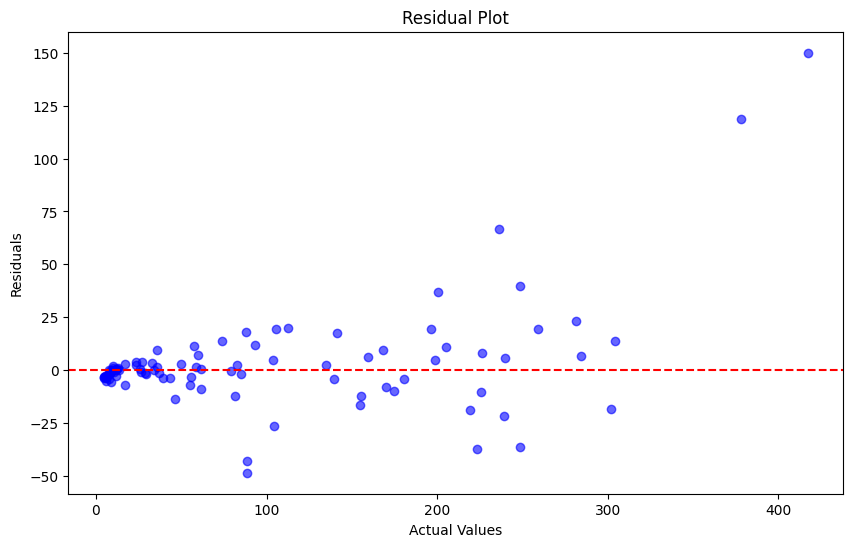

In [19]:
# Calculate residuals
residuals = Y_test - y_pred

# Create scatter plot of actual vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, residuals, color='blue', alpha=0.6)

# Add a horizontal line at zero for reference
plt.axhline(y=0, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Show the plot
plt.show()

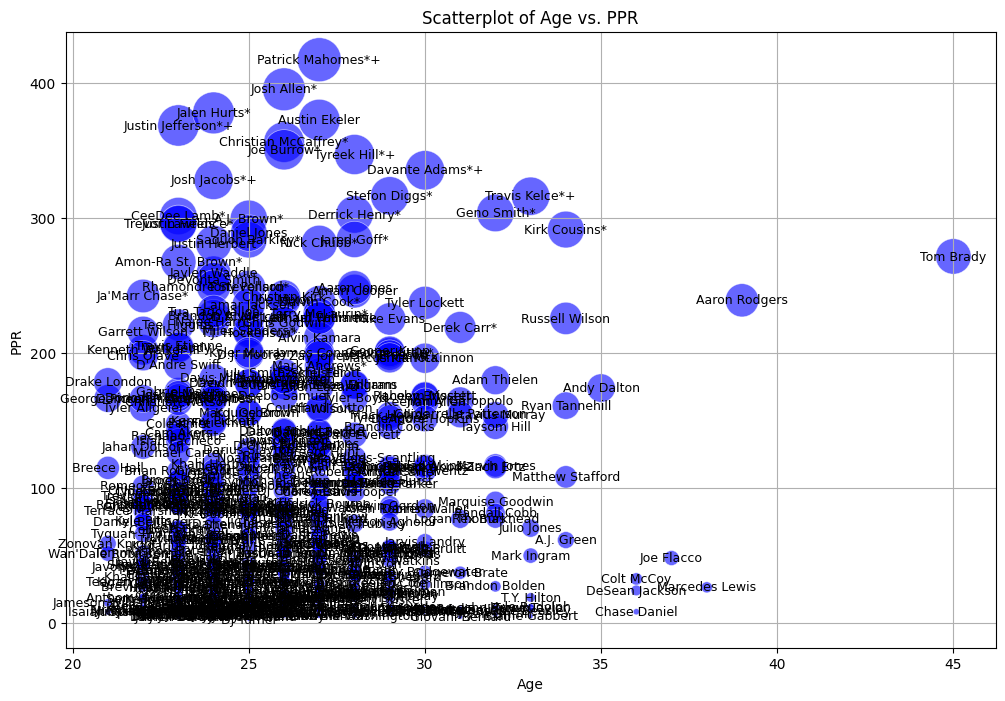

In [17]:
# Create the scatterplot
plt.figure(figsize=(12, 8))

# Scatterplot with sizes proportional to 'PPR'
scatter = plt.scatter(
    x=df['Age'],
    y=df['PPR'],
    s=df['PPR'] / df['PPR'].max() * 1000,  # Scale size for visibility
    alpha=0.6,  # Transparency
    c='blue',  # Color
    edgecolors='w',  # White edge for better visibility
    linewidth=0.5
)

# Add player names inside circles
for i in range(len(df)):
    plt.text(
        df['Age'][i],
        df['PPR'][i],
        df['Player'][i],
        fontsize=9,
        ha='center',
        va='center'
    )

# Add title and labels
plt.title('Scatterplot of Age vs. PPR')
plt.xlabel('Age')
plt.ylabel('PPR')

# Add grid
plt.grid(True)

# Show the plot
plt.show()